IntSlider(value=3, description='Кластеры: ', max=10, min=2)

IntSlider(value=11, description='Порог: ', max=20, min=1)

Расстояние между образами:


RadioButtons(description='Mode: ', options=('Манхеттонский', 'Канберра'), value='Манхеттонский')

Расстояние между кластерами:


RadioButtons(description='Mode: ', options=('Между центрами', 'Ближнего соседа'), value='Между центрами')

Нормирование данных:


Checkbox(value=False)

Введение весов:


Checkbox(value=False)

Поворот области отображения:


IntSlider(value=30, description='Vertical:', max=90, min=1)

IntSlider(value=60, description='Horizontal:', max=90, min=1)

Button(description='Запустить', style=ButtonStyle())

Результат кластеризации:


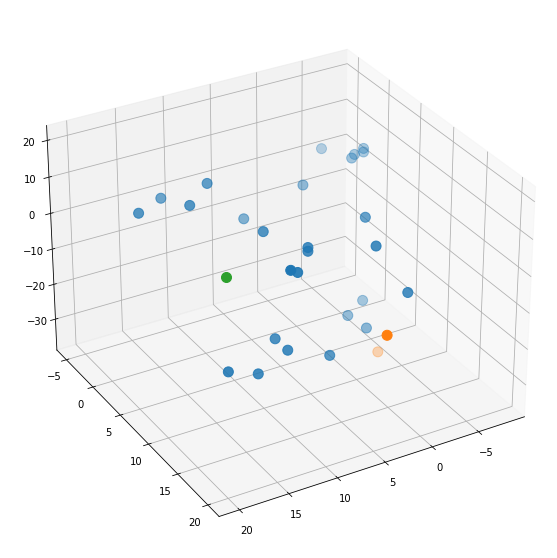

In [33]:
from math import sqrt 
import ipywidgets as widgets

from IPython.display import display

from IPython.display import clear_output 
import matplotlib.pyplot as plt 
import copy as cp

from math import sqrt

from mpl_toolkits.mplot3d import Axes3D

#мн-во образов
mn = [(15,6,15), (1,19,0), (-8,-1,4), (13,19,15), (15,17,-14), (-3,9,-35), 
      (12,4,16), (8, 14,9), (-6,0,5), (11,17,10), (12,17,-10), (-1,10,-25), 
      (18,17,-11), (-4,9,-31), (19, 4,13), (8,14,10), (-6,-5,1), (20,20,20), 
      (7,16,-17), (-1,7,-26), (15,1,10), (0,11,8), (-8,-1,5), (10,10,10), 
      (12,15,-10), (-4,5,-27), (-7,-1,4), (3,17,11), (0,1,3), (7,2,0)]

#test_mn = [(10,10,0),(12,10,0),(14,10,0),(14,5,0),(14,1,0),(12,1,0),(10,1,0),(13,3,0)]

#формируем данные для отображения
data = []
x,y,z = [],[],[]
for i in mn:
    data.append([i[0],i[1],i[2]])
    x.append(i[0])
    y.append(i[1])
    z.append(i[2])

fig = plt.figure(figsize=(12.,10.))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 60)
ax.scatter(x,y,z,s=100)

#метод манхэттонский
def manhettonskiy(a,b,h=False):
    d = 0
    if(h != False):
        for i in range(len(a)):
            d += h[i]*abs(a[i]-b[i]) #учет веса
    else:
        for i in range(len(a)):
            d += abs(a[i]-b[i])
    return d

#метод канберра
def kanberra(a,b,h=False):
    d = 0
    if(h != False):
        for i in range(len(a)):
            if (abs(a[i]) + abs(b[i]) == 0):
                d += 0
            else:
                d += h[i]*abs(a[i]-b[i])/(abs(a[i]) + abs(b[i])) #учет веса
    else:
        for i in range(len(a)):
            if (abs(a[i]) + abs(b[i]) == 0):
                d += 0
            else:
                d += abs(a[i]-b[i])/(abs(a[i]) + abs(b[i]))
    return d
                
#расстояние между центрами разных кластеров
def center(a,b, method,h=False):
    p1 = [sum([i[0] for i in a])/len(a),sum([i[1] for i in a])/len(a),sum([i[2] for i in a])/len(a)]
    p2 = [sum([i[0] for i in b])/len(b),sum([i[1] for i in b])/len(b),sum([i[2] for i in b])/len(b)]
    return method(p1,p2,h)

#расстояние между ближайшими точками разных кластеров
def dclose(a,b,method,h=False):
    ds = []
    for i in a:
        for j in b:
            ds.append(method(i,j,h))
    return min(ds)

#кластеризация методом слияния
def cluster(data,imageDistanceMode,clusterDistanceMode,targetClusterSize,p, h=False):
    clusterSize = len(data) #начальное кол-во кластеров

    #все элементы принадлежат разным кластерам
    cls = {}
    for i in range(clusterSize):
        cls[i] = [data[i]]
        
    while(clusterSize != targetClusterSize):
        #формируем расстояния между кластерами, чтобы далее два самых близких из них слить в один
        ds = {}
        for i,pts1 in cls.items():
            ds[i] = {}
            for j,pts2 in cls.items():
                if(i != j):
                    ds[i][j] = clusterDistanceMode(pts1,pts2,imageDistanceMode,h)
            
        #находим минимум расстояния между кластерами
        idx = next(iter(ds))
        jdx = next(iter(ds[idx]))
        for i,pts1 in ds.items():
            for j,pts2 in pts1.items():
                if(ds[idx][jdx] > ds[i][j]):
                    idx = i
                    jdx = j

            if(ds[idx][jdx] > p):
                break;   
        cls[idx] += cls[jdx] #добавляем данные в первый найденный кластер
        del cls[jdx] #убираем данные из второго найденного кластера
        clusterSize -= 1 #уменьшаем кол-во кластеров на 1
    
    return cls #возвращаем сформированные кластеры

#нормализация данных
def normalize(data):
    #нормировка данных методом минимакса
    mx = [max(i[0] for i in data),max(i[1] for i in data),max(i[2] for i in data)]
    ms = [min(i[0] for i in data),min(i[1] for i in data),min(i[2] for i in data)]
    norm = []
    for d in data:
        norm.append(d)
        for i in range(len(d)):
            if(mx[i]-ms[i] != 0): 
                norm[len(norm)-1][i] = (d[i] - ms[i])/(mx[i]-ms[i])
    return norm

#расчет дисперсии
def disp(ls):
    avg = sum(ls)/len(ls)
    d = 0
    for i in ls:
        d += (i-avg)**2
    return d/len(ls)

#получение весов
def weights(norm):
    h = []
    for i in range(3):
        h.append(1/disp([b[i] for b in norm]))
    return h

#отрисовка меню выбора параметров и самого 3д графика

#отрисовка 3d рисунка
def paint3d(cls,a=30,b=60):
    fig = plt.figure(figsize=(12.,10.))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(a, b)
    for k,v in cls.items():
        x,y,z = [p[0] for p in v],[p[1] for p in v],[p[2] for p in v]
        ax.scatter(x,y,z,s=100,depthshade=True)

#кол-во кластеров
clasterCountSlider = widgets.IntSlider(
    description='Кластеры: ',
    min=2,
    max=10,
    step=1,
    value=3
)

#порог
borderValueSlider = widgets.IntSlider(
    description='Порог: ',
    min=1,
    max=20,
    step=1, 
    value=18
)

#первый метод - расчет расстояния между образами
imageDistanceMode = widgets.RadioButtons(
    description='Mode: ',
    options=['Манхеттонский', 'Канберра'],
    disabled=False
)

#второй метод - расчет расстояния между кластерами
clasterDistanceMode = widgets.RadioButtons(
    description = "Mode: ",
    options=['Между центрами', 'Ближнего соседа'],
    disabled=False
)

#ввод нормализации данных
dataNormalizationModeBox = widgets.Checkbox(False)

#ввод весов
dataWeightModeBox = widgets.Checkbox(False)

#поворот рисунка по вертикали
verticalSpin = widgets.IntSlider(
    min=1,
    max=90,
    step=1,
    description='Vertical:',
    value=30
)

#поворот рисунка по горизонтали
horizontalSpin = widgets.IntSlider(
    min=1,
    max=90,
    step=1,
    description='Horizontal:',
    value=60
)

#кнопка для применения изменений
start = widgets.Button(description='Запустить')

#данные для тестирования
dataset = cp.deepcopy(data)

#для упрощения
def menu():
    display(clasterCountSlider)
    display(borderValueSlider)
    print('Расстояние между образами:')
    display(imageDistanceMode)
    print('Расстояние между кластерами:')
    display(clasterDistanceMode)
    print('Нормирование данных:')
    display(dataNormalizationModeBox)
    print('Введение весов:')
    display(dataWeightModeBox)
    print('Поворот области отображения:')
    display(verticalSpin)
    display(horizontalSpin)
    display(start)

#метод для применения изменений
def on_change(btn):
    dataset = cp.deepcopy(data)
    clear_output()
    menu()
    selectedImageDistanceMode = imageDistanceMode.value #первый метод
    selectedClasterDistanceMode = clasterDistanceMode.value #второй
    clasterCount = clasterCountSlider.value #кол-во кластеров
    isNormalized = dataNormalizationModeBox.value #с нормализацией
    isWeightMode = dataWeightModeBox.value #с весами
    h = False
    borderValue = borderValueSlider.value
    if(selectedImageDistanceMode == 'Манхеттонский'):
        selectedImageDistanceMode = manhettonskiy
    else:
        selectedImageDistanceMode = kanberra
    if(selectedClasterDistanceMode == 'Между центрами'):
        selectedClasterDistanceMode = center
    else:
        selectedClasterDistanceMode = dclose
    if(isNormalized):
        borderValue = (borderValue-1)/(19) #порог тоже нормализуем
        dataset = normalize(dataset)
    if(isWeightMode):
        h = weights(dataset)
    cls = cluster(dataset,selectedImageDistanceMode,selectedClasterDistanceMode,clasterCount, borderValue, h)
    print('Результат кластеризации:')
    paint3d(cls,verticalSpin.value,horizontalSpin.value)
 
menu()
start.on_click(on_change)